In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#!pip install missingno
import missingno as msno

#!pip install plotly
import plotly.express as px
pd.options.plotting.backend = "plotly"

<AxesSubplot:>

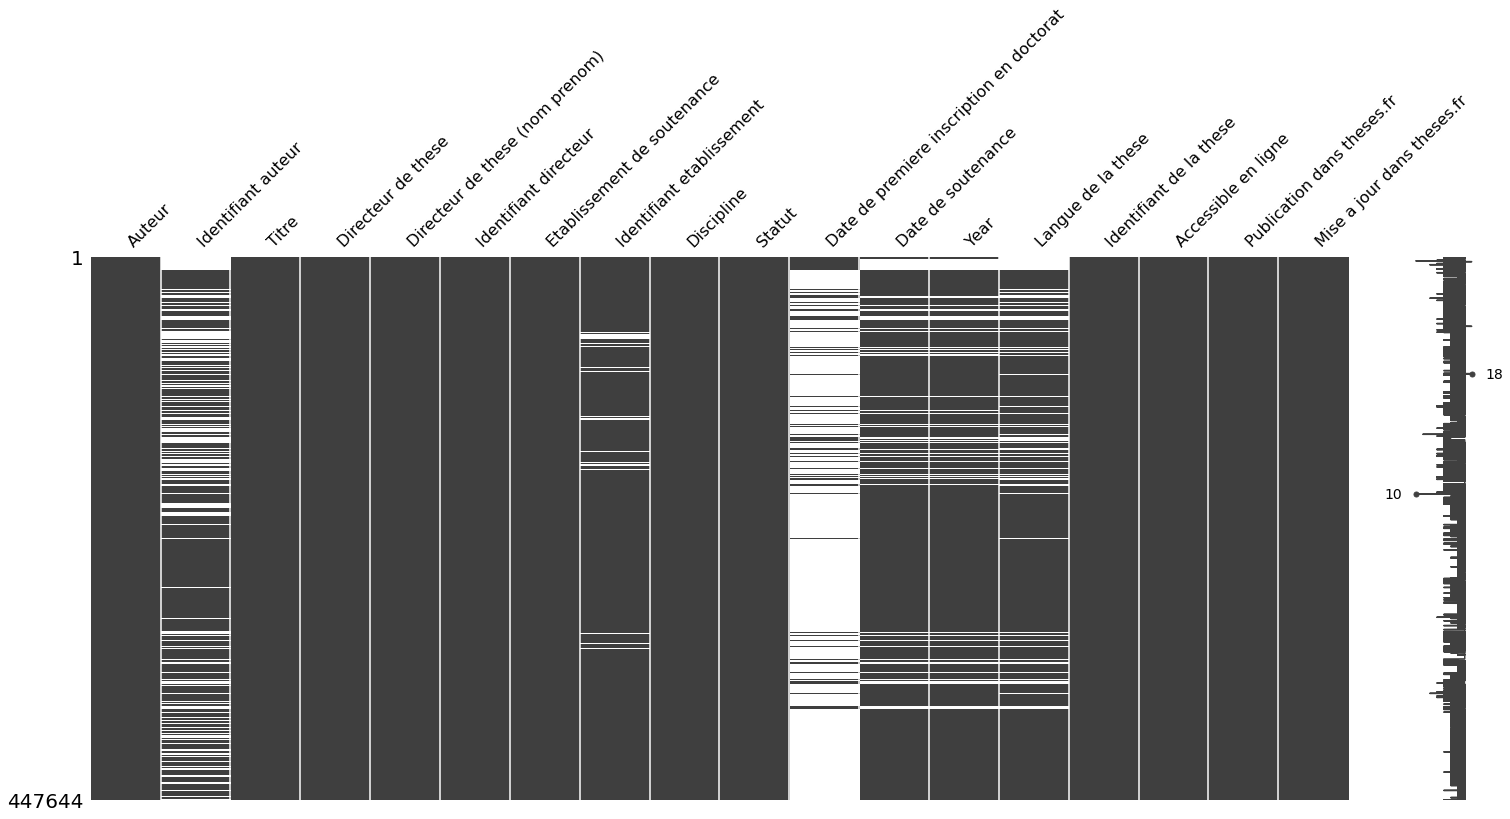

In [2]:
df = pd.read_csv('datasets/theses_v2.csv', encoding='latin-1', low_memory=False)
msno.matrix(df)

In [3]:
df.dropna(subset=['Date de soutenance'], inplace=True)
df['Date de soutenance'] = pd.DatetimeIndex(df['Date de soutenance'])
years = df.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1).set_index('Year')

In [4]:
df_0101 = df[df['Date de soutenance'].apply(lambda x: np.logical_and(x.day == 1, x.month == 1))]
df_0101['Year'] = df_0101['Date de soutenance'].apply(lambda x: x.year)
df_0101 = df_0101.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1)
df_0101.rename(columns={'Titre' : 'nb_Thesis'}, inplace=True)
df_0101['nb_Thesis_byyear'] = df_0101['Year'].apply(lambda x: years.loc[x])
df_0101['Percentage'] = df_0101['nb_Thesis'] / df_0101['nb_Thesis_byyear'] * 100
df_0101.plot(x='Year', y='Percentage', title='Pecentage of thesis defended at New Year')

/var/folders/lg/3cfjf86d1ll_sbdjpdpm8p840000gn/T/ipykernel_10165/680479542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0101['Year'] = df_0101['Date de soutenance'].apply(lambda x: x.year)


In [5]:
df = df[df['Date de soutenance'].apply(lambda x: np.logical_and(x.year > 2010, np.logical_or(x.day != 1, x.month != 1)))]
df['Month'] = df['Date de soutenance'].apply(lambda x: x.month)
df['Year'] = df['Date de soutenance'].apply(lambda x: x.year)

In [6]:
df_months = df.groupby(['Year', 'Month']).count().reset_index().reindex(['Year', 'Month', 'Titre'], axis=1)
df_months.rename(columns={'Titre' : 'nb_Thesis'}, inplace=True)
df_months['nb_Thesis_byyear'] = df_months['Year'].apply(lambda x: years.loc[x])
df_months['Percentage'] = df_months['nb_Thesis'] / df_months['nb_Thesis_byyear'] * 100
df_months['Time'] = pd.to_datetime(df_months[['Year', 'Month']].assign(day=1))

In [7]:
df_months.plot(x='Time', y='Percentage', title='Percentage of thesis defended by month')

In [8]:
df_months.groupby('Month').mean().reset_index().plot.bar(x='Month', y='Percentage', title='Percentage of thesis defended during the year')

Create gender column using gender-guesser library

In [9]:
#!pip install gender-guesser
import gender_guesser.detector as gender
import re

df[['first_name','last_name']] = df['Auteur'].apply(lambda s: re.sub('\([^\)]+\)', '', s).rstrip()).str.split(' ', 1, expand=True)
detector = gender.Detector(case_sensitive=False)
df['Gender'] = df['first_name'].apply(lambda s: detector.get_gender(s))
rename_dict = {'mostly_female': 'female', 'mostly_male': 'male'}
df['Gender'].replace(rename_dict, inplace=True)
df.drop(df[np.logical_or(df['Gender'] == 'unknown', df['Gender'] == 'andy')].index, inplace=True)

In [10]:
df_gender = df.groupby('Gender').count().reset_index().rename(columns={'Auteur' : 'nb_Thesis'})
px.pie(df_gender, values='nb_Thesis', names='Gender')